In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("((?:[A-Z-][ ]){9,}[A-Z])\s+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=(?:[A-Z][ ]){9,}|This book \n)")      # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
#         chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
stop_words = stopwords.words('english')

In [5]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [13]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
start=5; stop=35; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model
Calculating 35-topic model


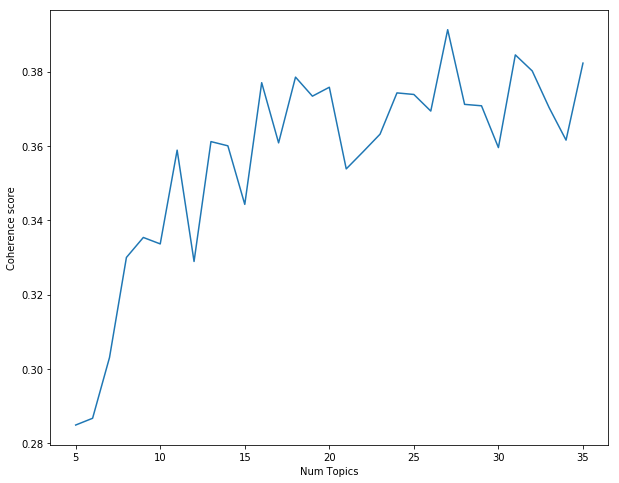

In [15]:
# Show graph
x = range(start, stop, step)
plt.figure(figsize=(10, 8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1

Num Topics = 5  has Coherence Value of 0.284863   Model index 0
Num Topics = 6  has Coherence Value of 0.286684   Model index 1
Num Topics = 7  has Coherence Value of 0.303036   Model index 2
Num Topics = 8  has Coherence Value of 0.32998   Model index 3
Num Topics = 9  has Coherence Value of 0.335364   Model index 4
Num Topics = 10  has Coherence Value of 0.333626   Model index 5
Num Topics = 11  has Coherence Value of 0.358872   Model index 6
Num Topics = 12  has Coherence Value of 0.328901   Model index 7
Num Topics = 13  has Coherence Value of 0.361173   Model index 8
Num Topics = 14  has Coherence Value of 0.360038   Model index 9
Num Topics = 15  has Coherence Value of 0.344273   Model index 10
Num Topics = 16  has Coherence Value of 0.377036   Model index 11
Num Topics = 17  has Coherence Value of 0.360832   Model index 12
Num Topics = 18  has Coherence Value of 0.378537   Model index 13
Num Topics = 19  has Coherence Value of 0.373405   Model index 14
Num Topics = 20  has Coher

In [17]:
# Select the model and print the topics
index = 15
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [20]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [21]:
len(bonus_words)

191

In [22]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [23]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [24]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Dursley's scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded an

At three-thirty that afternoon, Harry, Ron, and the other Gryffindors hurried down the front steps onto the grounds for their first flying lesson.
Harry saw his scared white face look down at the ground falling away, saw him gasp, slip sideways off the broom and — WHAM — a thud and a nasty crack and Neville lay facedown on the grass in a heap.
All the same, it wasn't what you'd call the perfect end to the day, Harry thought, as he lay awake much later listening to Dean and Seamus falling asleep (Neville wasn't back from the hospital wing).
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped down one corridor then another, Harry in the lead, without any idea where they were or where they were going — they ripped through a tapestry and found themselves in a hidden passageway, hurtled along it and came out near their Charms classroom, which they knew was miles from the trophy room.


"Harry Potter is humble and modest," said Dobby reverently, his orb-like eyes aglow.
"Dobby heard tell," he said hoarsely, "that Harry Potter met the Dark Lord for a second time, just weeks ago .
"Not — not He-Who-Must-Not-Be-Named, sir —" But Dobby's eyes were wide and he seemed to be trying to give Harry a hint.
"Harry Potter will have them, sir, if he gives Dobby his word 'S WARNING
He saw Dobby's face in the crowd and shouted out, asking for help, but Dobby called, "Harry Potter is safe there, sir!"

Chapter 3 - THE BURROW
"If the Dursleys wake up, I'm dead," said Harry as he tied the rope tightly around a bar and Fred revved up the car.
The car revved louder and louder and suddenly, with a crunching noise, the bars were pulled clean out of the window as Fred drove straight up in the air.
"One good push —" Harry and George threw their shoulders against the trunk and it slid out of the window into the back seat of the car.
But the Weasleys gave a gigantic tug and Harry's leg slid ou

Snape prowled through the fumes, making waspish remarks about the Gryffindors' work while the Slytherins sniggered appreciatively.
As half the class lumbered up to Snape's desk, some weighted down with arms like clubs, others unable to talk through gigantic puffed-up lips, Harry saw Hermione slide back into the dungeon, the front of her robes bulging.
Lockhart shouted in alarm over the heads of the battling crowd, as Malfoy sank to his knees; Harry had hit him with a Tickling Charm, and he could barely move for laughing.
said Lockhart, gesturing Harry and Malfoy into the middle of the hall as the crowd backed away to give them room.
By next morning, however, the snow that had begun in the night had turned into a blizzard so thick that the last Herbology lesson of the term was canceled: Professor Sprout wanted to fit socks and scarves on the Mandrakes, a tricky operation she would entrust to no one else, now that it was so important for the Mandrakes to grow quickly and revive Mrs. Norr

He could even go wherever he pleased, as long as it was in Diagon Alley, and as this long cobbled street was packed with the most fascinating wizarding shops in the world, Harry felt no desire to break his word to Fudge and stray back into the Muggle world.
Harry ate breakfast each morning in the Leaky Cauldron, where he liked watching the other guests: funny little witches from the country, up for a day's shopping; venerable-looking wizards arguing over the latest article in Transfiguration Today; wild-looking warlocks; raucous dwarfs; and once, what looked suspiciously like a hag, who ordered a plate of raw liver from behind a thick woollen balaclava.
After breakfast Harry would go out into the backyard, take out his wand, tap the third brick from the left above the trash bin, and stand back as the archway into Diagon Alley opened in the wall.
Curious to know what the crowd in the shop was staring at, Harry edged his way inside and squeezed in among the excited witches and wizards un

The last thing anyone felt like doing was spending two hours on the grounds on a raw January morning, but Hagrid had provided a bonfire full of salamanders for their enjoyment, and they spent an unusually good lesson collecting dry wood and leaves to keep the fire blazing while the flame-loving lizards scampered up and down the crumbling, white-hot logs.
Professor Lupin continued, "The Patronus is a kind of positive force, a projection of the very things that the dementor feeds upon — hope, happiness, the desire to survive — but it cannot feel despair, as real humans can, so the dementors can't hurt it.
He pulled off the lid of the case for the third time, and the dementor rose out of it; the room fell cold and dark — "EXPECTO PATRONUM!"
The screaming inside Harry's head had started again — except this time, it sounded as though it were coming from a badly tuned radio — softer and louder and softer again — and he could still see  the dementor — it had halted — and then a huge, silver s

"We've gone back in time," Hermione whispered, lifting the chain off Harry's neck in the darkness.
And sure enough, moments later, Hagrid's back door opened, and Harry saw himself, Ron, and Hermione walking out of it with Hagrid.
but the Harry and Hermione hidden in the trees could now hear what was happening inside the cabin through the back door.
This is it, Hermione —" Hermione put her hands on Buckbeak's back and Harry gave her a leg up.
Harry and Hermione jumped back as the enormous wings rose once more.


Harry Potter and the Goblet of Fire
Chapter 1 - THE RIDDLE HOUSE
The villagers of Little Hangleton still called it "the Riddle House," even though it had been many years since the Riddle family had lived there.
Every version of the tale, however, started in the same place: Fifty years before, at daybreak on a fine summer's morning, when the  Riddle House had still been well kept and impressive, a maid had entered the drawing room to find all three Riddles dead.
But over in the n

The great shamrock dissolved, the leprechauns drifted down onto the field on the opposite side from the veela, and settled themselves cross-legged to watch the match.
Harry spun the speed dial on his Omnioculars back to normal, watching closely as Mostafa mounted his broomstick and kicked the crate open — four balls burst into the air: the scarlet Quaffle, the two black Bludgers, and (Harry saw it for the briefest moment, before it sped out of sight) the minuscule, winged Golden Snitch.
Harry spun the slow dial on the right of his Omnioculars again, pressed the play-by-play button on the top, and he was immediately watching in slow motion, while glittering purple lettering flashed across the lenses and the noise of the crowd pounded against his eardrums.
But the cheers of the Irish supporters were barely heard over the shrieks of the veela, the blasts now issuing from the Ministry members' wands, and the furious roars of the Bulgarians.
"And as the Irish team performs a lap of honor, f

Harry will just have to do the best he —" The door behind them opened again, and a large group of people came in: Professor Dumbledore, followed closely by Mr. Crouch, Professor Karkaroff, Madame Maxime, Professor McGonagall, and Professor Snape.
Harry heard the buzzing of the hundreds of students on the other side of the wall, before Professor McGonagall closed the door.
Professor Dumbledore was now looking down at Harry, who looked right back at him, trying to discern the expression of the eyes behind the half-moon spectacles.
Insisting that he needed to sleep, and almost flattening the little Creevey brothers as they attempted to waylay him at the foot of the stairs, Harry managed to shake everyone off and climb up to the dormitory as fast as he could.
He wrenched the hangings shut around his four-poster, leaving Harry standing there by the door, staring at the dark red velvet curtains, now hiding one of the few people he had been sure would believe him.

Chapter 18 - THE WEIGHING O

Ron and Harry wasted no time in telling Hermione about the conversation they had overheard between Madame Maxime and Hagrid, but Hermione didn't seem to find the news that Hagrid was a half-giant nearly as shocking as Ron did.
honestly, all this hysteria about giants.
Hermione went slightly pink, but Dumbledore smiled at her and continued, "Hermione, Harry, and Ron still seem to want to know you, judging by the way they were attempting to break down the door."
Harry, Ron, and Hermione looked at one another nervously; Harry would rather have taken fifty Blast-Ended Skrewts for a walk than admit to Hagrid that he had overheard him talking to Madame Maxime, but Hagrid was still talking, apparently unaware that he had said anything odd.
Harry went back to the castle later that afternoon with Ron and Hermione, unable to banish the image of the happy expression on'S SCOOP

Chapter 25 - THE EGG AND THE EYE
The map showed the whole of Hog-warts, including its many shortcuts and secret passagew

Voldemort bent down and pulled out Wormtail's left arm; he forced the sleeve of Wormtail's robes up past his elbow, and Harry saw something upon the skin there, something like a vivid red tattoo — a skull with a snake protruding from its mouth — the image that had appeared in the sky at the Quidditch World Cup: the Dark Mark.
The Death Eater on the ground writhed and shrieked; Harry was sure the sound must carry to the houses around.
Then the Death Eater to the right of Worm-tail stepped forward, and Lucius Malfoy's voice spoke from under the mask.
Use my Death Eater to ensure that the boy won the tournament — that he touched the Triwizard Cup first — the cup which my Death Eater had turned into a Portkey, which would bring him here, beyond the reach of Dumbledore's help and protection, and into my waiting arms.
The night was ringing with the sound of the Death Eaters' laughter.

Chapter 34 - PRIORI INCANTATEM
There was a split second, perhaps, when Harry might have considered running 

"Oh no — sorry —" "Here, dear," said Mrs. Weasley, sounding exasperated, and she repaired the parchment with a wave of her wand: In the flash of light caused by Mrs. Weasley's charm, Harry caught a glimpse of what looked like the plan of a building.
The stew skidded the length of the table and came to a halt just before the end, leaving a long black burn on the wooden surface, the flagon of butterbeer fell with a crash, spilling its contents everywhere, and the bread knife slipped off the board and landed, point down and quivering ominously, exactly where Sirius's right hand had been seconds before.
"Boys," Mr. Weasley said, lifting the stew back into the middle of the table, "your mother's right, you're supposed to show a sense of responsibility now you've come of age —" "— none of your brothers caused this sort of trouble!"
"He hasn't stopped raging about the Bagman business, he reckons the Ministry did a cover-up, those goblins never got their gold from him, you know —" A gale of la

Then the rip near the hat's brim opened wide like a mouth and the Sorting Hat burst into song: In times of old when I was new And Hogwarts barely started The founders of our noble school Thought never to be parted: United by a common goal, They had the selfsame yearning, To make the world's best magic school And pass along their learning.
And now the Sorting Hat is here And you all know the score: I sort you into Houses Because that is what I'm for, But this year I'll go further, Listen closely to my song: Though condemned I am to split you Still I worry that it's wrong, Though I must fulfill my duty And must quarter every year Still I wonder whether sorting May not bring the end I fear.
The Sorting Hat usually confined itself to describing the different qualities looked for by each of the four Hogwarts Houses and its own role in sorting them; Harry could not remember it ever trying to give the school advice before.
"The hat feels itself honor-bound to give the school due warning whene

Harry felt happier for the rest of the weekend than he had done all term.
The knowledge that they were doing something to resist Umbridge and the Ministry, and that he was a key part of the rebellion, gave Harry a feeling of immense satisfaction.
The above is in accordance with Educational Decree Number Twenty-four.
high inquisitor Harry and Ron read the notice over the heads of some anxious-looking second years.
"Yes," said Harry, lifting Hedwig carefully off his shoulder, "she turned up after the other post owls and her wing's all funny, look —" Professor Grubbly-Plank stuck her pipe firmly between her teeth and took Hedwig from Harry while Professor McGonagall watched.

Chapter 17 - DUMBLEDORE
said Professor Flitwick's squeaky little voice and Harry, Ron, and Hermione all jumped.
"Mimbulus mimbletonia," said Ron's voice and Harry came back to his senses just in time to clamber through the portrait hole into the common room.
At half-past seven Harry, Ron, and Hermione left the Gryffi

"I am here on Dumbledore's orders," said Snape, whose voice, by contrast, was becoming more and more quietly waspish, "but by all means stay, Black, I know you like to feel .
Harry yelled, vaulting over the table and trying to get in between them, "Sirius, don't —"OCCLUMENCY
Harry sat down and so did Snape, his cold black eyes fixed unblinkingly upon Harry, dislike etched in every line of his face.CHAPER WENY-FOUR
Snape had struck before Harry was ready, before Harry had even begun to summon any force of resistance: the office swam in front of his eyes and vanished, image after image was racing through his mind like a flickering film so vivid it blinded him to his surroundings.
He could not help feeling that his first foray into Occlumency had weakened his mind's resistance rather than strengthening it, and he wondered, with a feeling of great trepidation, what had happened to make Lord Voldemort the happiest he had been in fourteen years.

Chapter 24 - THE BEETLE AT BAY
For an answer 

The purposeful, feverish atmosphere drove nearly everything but the O.W.L.s from Harry's mind, though he did wonder occasionally during Potions lessons whether Lupin had ever told Snape that he must continue giving Harry Occlumency tuition: If he had, then Snape had ignored Lupin as thoroughly as he was now ignoring Harry.
Harry thought Professor Marchbanks must be the tiny, stooped witch with a face so lined it looked as though it had been draped in cobwebs; Umbridge was speaking to her very deferentially.
said Professor Umbridge as Harry, Ron, and Hermione dragged their feet up the marble staircase as slowly as they dared, "let me show you to the staffroom .
Then, at half-past nine, they were called forward class by class to reenter the Great Hall, which was now arranged exactly as Harry had seen it inCHAPTER THIRTY-ONE
Neville, who was sitting very near Harry, also looked happier than Harry had ever seen him during a Potions class.

Chapter 31 - OUT OF THE FIRE I
He waited for the s

"I cared more for your happiness than your knowing the truth, more for your peace of mind than my plan, more for your life than the lives that might be lost if the plan failed.
"It meant," said Dumbledore, "that the person who has the only chance of conquering Lord Voldemort for good was born at the end of July, nearly sixteen years ago.
"But you said — Neville was born at the end of July too — and his mum and dad —" "You are forgetting the next part of the prophecy, the final identifying feature of the boy who could vanquish Voldemort.
"He heard only the first part, the part foretelling the birth of a boy in July to parents who had thrice defied Voldemort.
He did not know that you would have 'power the Dark Lord knows not' —" "But I don't!"


Harry Potter and the Half-Blood Prince
Chapter 1 - THE OTHER MINISTER
When several carpenters, a builder or two, an art historian, and the Chancellor of the Exchequer had all tried unsuccessfully to prise it from the wall, the Prime Minister had 

"He and Professor Trelawney are dividing classes between them this year," said Professor McGonagall, a hint of disapproval in her voice; it was common knowledge that she despised the subject of Divination.
They returned to the common room, which was empty apart from a half dozen seventh years, including Katie Bell, the only  remaining member of the original Gryffindor Quidditch team that Harry had joined in his first year.
"Now then," said Slughorn, returning to the front of the class and inflating his already bulging chest so that the buttons on his waistcoat threatened to burst off, "I've prepared a few potions for you to have a look at, just out of interest, you know.
Harry too had recognized the slow-bubbling, mudlike substance in the second cauldron, but did not resent Hermione getting the credit for answering the question; she, after all, was the one who had succeeded in making it, back in their second year.
The whole class seemed to sit up a little straighten Now all Harry could

"Great," said Harry, unrolling it at once to discover that his next lesson with Dumbledore was scheduled for the following night.
If you are seventeen years of age, or will turn seventeen on or before the 31st August next, you are eligible for a twelve-week course of Apparition Lessons from a Ministry of Magic Apparition instructor.
"Harry's already Apparated," Ron told a slightly abashed Seamus, after Professor Flitwick had dried himself off with a wave of his wand and set Seamus lines: "I am a wizard, not a baboon brandishing a stick."
All of them seemed awed, rather than put off, when he told them how uncomfortable it was, and he was still answering detailed questions at ten to eight that evening, when he was forced to lie and say that he needed to return a book to the library, so as to escape in time for his lesson with Dumbledore.
"So," said Dumbledore, in a ringing voice, "we meet this evening to continue the tale of Tom Riddle, whom we left last lesson poised on the threshold of

Exhausted but delighted with his night's work, Harry told Ron and Hermione everything that had happened during next morning's Charms lesson (having first cast the Muffliato spell upon those nearest them).
They were both satisfyingly impressed by the way he had wheedled the memory out of Slughorn and positively awed when he told them about Voldemort's Horcruxes and Dumbledore's promise to take Harry along, should he find another one.
Malfoy's hex missed Harry by inches, shattering the lamp on the wall beside him; Harry threw himself sideways, thought Levicorpus!
There was a loud bang and the bin behind Harry exploded; Harry attempted a Leg-Locker Curse that backfired off the wall behind Malfoy's ear and smashed the cistern beneath Moaning Myrtle, who screamed loudly; water poured everywhere and Harry slipped as Malfoy, his face contorted, cried, "Cruci —" "!"
Would he tell Slughorn — Harry's stomach churned — how Harry had been achieving such good results in Potions all year?

Chapter 2

by Elphias Doge I met Albus Dumbledore at the age of eleven, on our first day at Hogwarts.
Albus Dumbledore was never proud or vain; he could find something to value in anyone, however apparently insignificant or wretched, and I believe that his early losses endowed him with great humanity and sympathy.
No doubt it would have felt strange, impertinent even, but after all, it had been common knowledge that Dumbledore had taken part in that legendary duel with Grindelwald, and Harry had not thought to ask Dumbledore what that had been like, nor about any of his other famous achievements.
and it seemed to Harry now, despite the fact that his future was so dangerous and so uncertain, that he had missed irreplaceable opportunities when he had failed to ask Dumbledore more about himself, even though the only personal question he had ever asked his headmaster was also the only one he suspected that Dumbledore had not answered honestly: "What do you see when you look in the mirror?"
The answer

Hermione called, half sobbing as she and Harry were buffeted by terrified guests: Harry seized her hand to make sure they weren't separated as a streak of light whizzed over their heads, whether a protective charm or something more sinister he did not know — And then Ron was there.
His companion, unable to see who had cast the spell, fired another at Ron: Shining black ropes flew from his wand-tip and bound Ron head to foot — the waitress screamed and ran for the door — Harry sent another Stunning Spell at the Death Eater with the twisted face who had tied up Ron, but the spell missed, rebounded on the window, and hit the waitress, who collapsed in front of the door.
We didn't kill you —" On the word kill, the figure exploded in a great cloud of dust: Coughing, his eyes watering, Harry looked around to see Hermione crouched on the floor by the door with her arms over her head, and Ron, who was shaking from head to foot, patting her clumsily on the shoulder and saying, "It's all r-right

quo;S HOLLOW
Harry was determined never to mention his name again, and Hermione seemed'S HOLLOW
Godric's Hollow, Godric Gryffindor, Gryffindor's sword; don't you think Dumbledore would have expected you to make the connection?"
Harry did not want to admit that he had not been thinking about the sword at all when he suggested they go to Godric's Hollow.
Harry would gladly have set out for Godric's Hollow the following day, but Hermione had other ideas.

Chapter 17 - BATHILDA
quo;S SECRET
The stairs were steep and narrow: Harry was half tempted to place his hands on stout Bathilda's backside to ensure that she did not topple over backward on top of him, which seemed only too likely.
Frozen air filled the room as Harry ducked to avoid another shower of broken glass and his foot slipped on a pencil-like something — his wand — He bent and snatched it up, but now the room was full of the snake, its tail thrashing; Hermione was nowhere to be seen and for a moment Harry thought the worst, but 

Bill and Fleur's cottage stood alone on a cliff overlooking the sea, its walls embedded with shells and whitewashed.
Harry had been staring out over the wall that separated the cottage garden from the cliff when Ron and Hermione had found him; he wished they had not, having no wish to join in with their argument.
"Look at the facts, Hermione," said Ron, speaking across Harry,CHAPTER TWENTY-FIVE
Griphook was waiting for them, as Fleur had said, in the tiniest of the cottage's three bedrooms, in which Hermione and Luna slept by night.
The other inhabitants of Shell Cottage could hardly fail to notice that something was going on now that Harry, Ron, and Hermione only emerged for mealtimes.

Chapter 26 - GRINGOTTS
"And you'll be using her actual wand," said Harry, nodding toward the walnut wand, "so I reckon you'll be pretty convincing."
Harry could not help but remember how Hermione had dismissed his loathing of the blackthorn wand, insisting that he was imagining things when it did not w

Harry's mind was in free fall, spinning out of control, unable to grasp the impossibility, because Fred Weasley could not be dead, the evidence of all his senses must be lying — And then a body fell past the hole blown into the side of the school, and curses flew in at them from the darkness, hitting the wall behind their heads.
Harry shouted, as more curses flew through the night: He and Ron had both grabbed Hermione and pulled her to the floor, but Percy lay across Fred's body, shielding it from further harm, and when Harry shouted, "Percy, come on, we've got to move!"
Harry called to the others, glancing over the edge of the castle through the hole in the wall the curses had blasted: More giant spiders were climbing the side of the building, liberated from the Forbidden Forest, into which the Death Eaters must have penetrated.
Harry yelled, and he, Ron, and Hermione gathered the Cloak tightly around themselves and pelted, heads down, through the midst of the fighters, slipping a lit